In [51]:
import os
import numpy as np
import nibabel as nib
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
import tensorflow as tf
from matplotlib import pyplot as plt
from skimage.transform import resize
from sklearn.model_selection import train_test_split
# u-net dependencies
from keras import backend as K
from keras.losses import binary_crossentropy
# elastic deform dependencies
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

In [52]:
x_path = 'data/2/rp_im'
y_path = 'data/2/rp_msk'
l_path = 'data/2/rp_lung_msk'

In [53]:
for i in range(9):
    curr_x = nib.load(x_path + '/' + str(i+1) + '.nii').get_fdata()
    curr_y = nib.load(y_path + '/' + str(i+1) + '.nii').get_fdata()
    curr_l = nib.load(l_path + '/' + str(i+1) + '.nii').get_fdata()
    
    if i == 0:
        x = curr_x
        y = curr_y
        l = curr_l
    else:
        x = np.concatenate((x, curr_x), axis=2)
        y = np.concatenate((y, curr_y), axis=2)
        l = np.concatenate((l, curr_l), axis=2)

<h4>Data has already been preprocessed with <a href="https://medium.com/@hbjenssen/covid-19-radiology-data-collection-and-preparation-for-artificial-intelligence-4ecece97bb5b">these</a> steps, except for the resize</h4>

In [54]:
print(x.shape)
print(y.shape)
print(l.shape)

x = x.T
y = y.T
l = l.T

print(x.shape)
print(y.shape)
print(l.shape)

(630, 630, 829)
(630, 630, 829)
(630, 630, 829)
(829, 630, 630)
(829, 630, 630)
(829, 630, 630)


In [55]:
num_of_imgs = np.size(x, axis=0)

resized_x = np.zeros((num_of_imgs, 512, 512, 1))
resized_y = np.zeros((num_of_imgs, 512, 512, 1))
resized_l = np.zeros((num_of_imgs, 512, 512, 1))

all_data = [[x, resized_x], [y, resized_y], [l, resized_l]]

for data in all_data:
    for i in range(num_of_imgs):
        resized_img = resize(data[0][i], (512, 512), preserve_range=True)
        
        data[1][i] = img_to_array(resized_img)

In [56]:
x_train, x_test, y_train, y_test = train_test_split(resized_x, resized_y, test_size=0.2, random_state=42)

# makes pixels range between 0 and 1
x_train = np.divide(x_train + np.abs(x_train.min()), (np.abs(x_train.min()) + x_train.max()))
x_test = np.divide(x_test + np.abs(x_test.min()), (np.abs(x_test.min()) + x_test.max()))

#print(x_train.max(), x_train.min(), x_train.mean(), x_test.max(), x_test.min(), x_test.mean())

# choose size of training set
pics = x_train.shape[0]
x_train, y_train = x_train[0:pics, :, :, :], y_train[0:pics, :, :, :]

In [57]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(663, 512, 512, 1)
(166, 512, 512, 1)
(663, 512, 512, 1)
(166, 512, 512, 1)


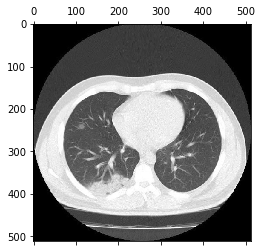

In [58]:
fig, ax = plt.subplots(1)
ax.matshow(array_to_img(x_train[30]), cmap='gray')

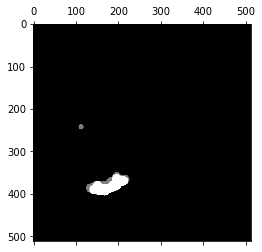

In [59]:
fig, ax = plt.subplots(1)
ax.matshow(array_to_img(y_train[30]), cmap='gray')

In [60]:
y_train = np.where(y_train >= 0.5, 1, 0) 
y_test = np.where(y_test >= 0.5, 1, 0) 

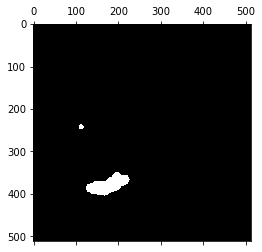

In [61]:
fig, ax = plt.subplots(1)
ax.matshow(array_to_img(y_train[30]), cmap='gray')

In [62]:
batch_size = 8
seed = 1
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

<h4>Elastic Deformations</h4>

In [63]:
# from https://gist.github.com/erniejunior/601cdf56d2b424757de5
def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]))

    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    distored_image = map_coordinates(image, indices, order=1, mode='reflect')
    return distored_image.reshape(image.shape)

In [64]:
x_train_elastic = np.zeros((x_train.shape[0], 512, 512, 1))
y_train_elastic = np.zeros((x_train.shape[0], 512, 512, 1))

# bestämmer elastiteten och deformationen
alpha = 1600
sigma = 6

for i in range(x_train.shape[0]):
    x_train_elastic[i] = elastic_transform(x_train[i], alpha, sigma)
    y_train_elastic[i] = elastic_transform(y_train[i], alpha, sigma)

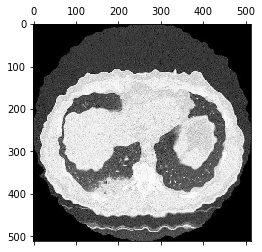

In [65]:
fig, ax = plt.subplots(1)
ax.matshow(array_to_img(x_train_elastic[6]), cmap='gray')

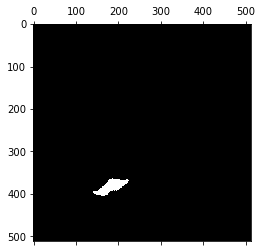

In [66]:
fig, ax = plt.subplots(1)
ax.matshow(array_to_img(y_train_elastic[6]), cmap='gray')

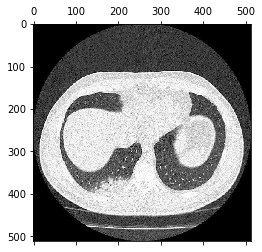

In [67]:
fig, ax = plt.subplots(1)
ax.matshow(array_to_img(x_train[6]), cmap='gray')

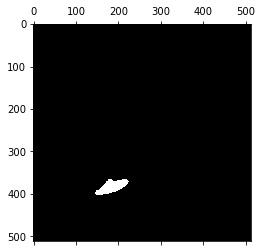

In [68]:
fig, ax = plt.subplots(1)
ax.matshow(array_to_img(y_train[6]), cmap='gray')

In [77]:
"""
# augmentation som jag tolkar original u-net-artikeln
data_gen_args = dict(rotation_range=15,
                     height_shift_range=0.1,
                     width_shift_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')
"""

# augmentation som jag tolkar original u-net-artikeln + zoom & channel_shift
data_gen_args = dict(rotation_range=15,
                     zoom_range=[0.9, 1.1],
                     height_shift_range=0.1,
                     width_shift_range=0.1,
                     channel_shift_range=0.15,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

image_datagen.fit(x_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

image_generator = image_datagen.flow(x_train, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(y_train, batch_size=batch_size, seed=seed)

#train_generator = zip(image_generator, mask_generator)
train_generator = (pair for pair in zip(image_generator, mask_generator))

val_gen_args = dict()

image_datagen_val = ImageDataGenerator(**val_gen_args)
mask_datagen_val = ImageDataGenerator(**val_gen_args)

image_datagen_val.fit(x_val, seed=seed)
mask_datagen_val.fit(y_val, seed=seed)

image_generator_val = image_datagen_val.flow(x_val, batch_size=batch_size, seed=seed)
mask_generator_val = mask_datagen_val.flow(y_val, batch_size=batch_size, seed=seed)

#val_generator = zip(image_generator_val, mask_generator_val)
val_generator = (pair for pair in zip(image_generator_val, mask_generator_val))

In [78]:
def u_net(img_width, img_height, img_channels, metrics, batch_norm=False, dropout=False, filters=16, optimizer='adam', loss_fn='dice'):
    
    def contract_layer(inputs, filters, dropout, drop, batch_norm, act='relu', kernel=(3, 3), pool_kernel=(2, 2)):
        use_bias = False if batch_norm else True
        conv = tf.keras.layers.Conv2D(filters, kernel, use_bias=use_bias, kernel_initializer='he_normal', padding='same')(inputs)
        conv = tf.keras.layers.BatchNormalization()(conv) if batch_norm else conv
        conv = tf.keras.layers.Activation(act)(conv)
        conv = tf.keras.layers.Dropout(drop)(conv) if dropout else conv
        conv = tf.keras.layers.Conv2D(filters, kernel, use_bias=use_bias, kernel_initializer='he_normal', padding='same')(conv)
        conv = tf.keras.layers.BatchNormalization()(conv) if batch_norm else conv
        conv = tf.keras.layers.Activation(act)(conv)
        pool = tf.keras.layers.MaxPooling2D(pool_size=pool_kernel)(conv)
        return conv, pool
    
    def expanse_layer(inputs, filters, conc, dropout, drop, batch_norm, act='relu', trans_kernel=(2, 2), strides=(2, 2), kernel=(3, 3), axis=-1):
        use_bias = False if batch_norm else True
        up = tf.keras.layers.Conv2DTranspose(filters, trans_kernel, strides=strides, padding='same')(inputs)
        up = tf.keras.layers.concatenate([up, conc], axis=axis)
        conv = tf.keras.layers.Conv2D(filters, kernel, use_bias=use_bias, kernel_initializer='he_normal', padding='same')(up)
        conv = tf.keras.layers.BatchNormalization()(conv) if batch_norm else conv
        conv = tf.keras.layers.Activation(act)(conv)
        conv = tf.keras.layers.Dropout(drop)(conv) if dropout else conv
        conv = tf.keras.layers.Conv2D(filters, kernel, use_bias=use_bias, kernel_initializer='he_normal', padding='same')(conv)
        conv = tf.keras.layers.BatchNormalization()(conv) if batch_norm else conv
        conv = tf.keras.layers.Activation(act)(conv)
        return conv
    
    # initialize inputs
    inputs = tf.keras.layers.Input((img_width, img_height, img_channels))
    
    # contractive path
    c1, p1 = contract_layer(inputs=inputs, filters=filters, dropout=dropout, drop=0.1, batch_norm=batch_norm)
    c2, p2 = contract_layer(inputs=p1, filters=2*filters, dropout=dropout, drop=0.1, batch_norm=batch_norm)
    c3, p3 = contract_layer(inputs=p2, filters=4*filters, dropout=dropout, drop=0.2, batch_norm=batch_norm)
    c4, p4 = contract_layer(inputs=p3, filters=8*filters, dropout=dropout, drop=0.2, batch_norm=batch_norm)
    c5, _ = contract_layer(inputs=p4, filters=16*filters, dropout=dropout, drop=0.3, batch_norm=batch_norm)
    
    # expansive path
    c6 = expanse_layer(inputs=c5, filters=8*filters, conc=c4, dropout=dropout, drop=0.2, batch_norm=batch_norm)
    c7 = expanse_layer(inputs=c6, filters=4*filters, conc=c3, dropout=dropout, drop=0.2, batch_norm=batch_norm)
    c8 = expanse_layer(inputs=c7, filters=2*filters, conc=c2, dropout=dropout, drop=0.1, batch_norm=batch_norm)
    c9 = expanse_layer(inputs=c8, filters=filters, conc=c1, dropout=dropout, drop=0.1, batch_norm=batch_norm, axis=3)
    
    # initialize outputs
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    # create model
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    
    # compile model
    def dice_coef(y_true, y_pred):
        smooth = 1.
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def bce_dice_loss(y_true, y_pred):
        return (0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred))
    
    def dice_loss(y_true, y_pred):
        return -dice_coef(y_true, y_pred)
    
    loss_fns = {'binary': 'binary_crossentropy', 'dice': bce_dice_loss}
    loss = loss_fns.get(loss_fn)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

In [79]:
model = u_net(img_width=512, img_height=512, img_channels=1, metrics=[tf.keras.metrics.MeanIoU(num_classes=2), tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()], batch_norm=True, dropout=True)

In [80]:
result_training = model.fit(train_generator, steps_per_epoch=np.floor(x_train.shape[0]/batch_size), epochs=2, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, verbose=1), tf.keras.callbacks.ModelCheckpoint('model-deep-test-1.h5', verbose=1, save_best_only=True)], validation_data=val_generator, validation_steps=np.floor(x_val.shape[0]/batch_size))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 74.0 steps, validate for 8.0 steps
Epoch 1/2
73/74 [============================>.] - ETA: 0s - loss: 0.1998 - mean_io_u_8: 0.4982 - true_positives_4: 4622234.0000 - true_negatives_4: 102046424.0000 - false_positives_4: 18553440.0000 - false_negatives_4: 27869984.0000
Epoch 00001: val_loss improved from inf to 0.25110, saving model to model-deep-test-1.h5
74/74 [==============================] - 32s 427ms/step - loss: 0.1986 - mean_io_u_8: 0.4982 - true_positives_4: 4622875.0000 - true_negatives_4: 103355008.0000 - false_positives_4: 18554362.0000 - false_negatives_4: 28656986.0000 - val_loss: 0.2511 - val_mean_io_u_8: 0.4952 - val_true_positives_4: 61376.0000 - val_true_negatives_4: 13579369.0000 - val_false_positives_4: 3036206.0000 - val_false_negatives_4: 100265.0000
Epoch 2/2
73/74 [============================>.] - ETA: 0s - loss: 0.0771 - mean_io_u_8: 0.4981 - true_positives_4: 33713.0000 - true_negatives_4: 118316728.0

In [81]:
res = model.predict(x_test, verbose=1)

166/166 [==============================] - 2s 12ms/sample


In [82]:
res = np.where(res > 0.5, 1, 0)

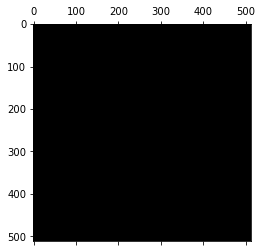

In [86]:
fig, ax = plt.subplots(1)
ax.matshow(array_to_img(res[1]), cmap='gray')

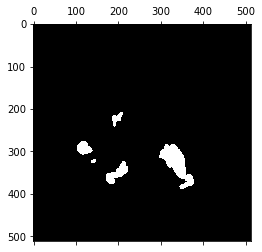

In [87]:
fig, ax = plt.subplots(1)
ax.matshow(array_to_img(y_test[3]), cmap='gray')

In [112]:
np.allclose(y_test[18, :, :, :], res[18, :, :, :])
print(np.unique(y_test[3]))
print(y_test.dtype)

[0 1]
int64


In [117]:
test_eval = model.evaluate(x_test, tf.cast(y_test, tf.float32))

166/166 [==============================] - 3s 17ms/sample - loss: 0.1451 - mean_io_u_8: 0.4963 - true_positives_4: 0.0000e+00 - true_negatives_4: 43192448.0000 - false_positives_4: 0.0000e+00 - false_negatives_4: 323458.0000


In [118]:
print(test_eval)

[0.14513731649123043, 0.49628347, 0.0, 43192450.0, 0.0, 323458.0]
